# Clasificador Binario

## Librerías

In [1]:
!pip install fastai -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     |████████████████████████████████| 197 kB 5.2 MB/s 
     |████████████████████████████████| 60 kB 7.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 5.1 MB/s 


{'restart': True, 'status': 'ok'}

In [1]:
from fastai.vision.all import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [2]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip


2022-06-16 07:35:31 URL:https://uc5d2ec36cb2170da05c82783876.dl.dropboxusercontent.com/cd/0/inline2/BnSyBWaVegyabhnB6WDF5n4x7BSZvbtzB2pgiLzOfDj6RefW73YUxQYUhFSnXxXR44KLYHYYDrt4on1mj9GZLt6DyeEmqNgfgpRsBp2-Qw4ILDUu_-LhKA71EUhKJ9xOPIJhxVNC4DCx2uwWALJpUTBBQjSeLVrHZ6H7K-8MWGlviu1EXYDW20kPDktlPqNN5tRnvhlHhHgOwwfHOX4B_dHCvJ5DcKzPNeNgiJI3vLuz0KonsO6YnYPRNIe_siRrSCinS5JZdDJmYclm1o1kjuDjxonvoo-IddX1A1uVAZdMzLqOqMpSqFoc_4P6njKgFP-LaXi48TCXg7PDoI1A9GLuU_clfEspXtmPLOlnSaA1LN0bgRyQOfnDv7FfZRRsO-5Wh4MKD6mB_asURpjZioPXR6TOpv7P1XX0LjklmWtuOw/file [138777773/138777773] -> "train.zip" [1]
2022-06-16 07:35:33 URL:https://uc0893fb7118e90c2b76444b0570.dl.dropboxusercontent.com/cd/0/inline2/BnTEv0vGXmgAkhSUbI_FzU_fxR18I3ZVYRb62KAQXLycgRUE9V3HgmdJPC4FszWckOAP5QFQCVmm-1p2NcQM2AEm0h2ROA19sxteLvT03sIY8INBkJVwKVQ9wTR1fsd8J1xYqIOIoUotSS2Zemj3LTRTYAtHLftNrWxQwaPgJXcdd6N_Ac7OlmjAqa2HmEIWLkCxklPvyEAlmc6kI8FFCWPUMGMNwNm3y49gtWWz8f5fI8fi8HvdlHqdW8X53ac64QTDjG272g65vaAaVL_m_nEQTriA_qioTzzSYJJi6QmRFph7D1V-u2HGB0QRyhLM6sD

In [3]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

Tenemos que cambiar la estructura del dataset


```.
└── dataset
    ├── train
    │   ├── normal
    │   └── enfermedad
    ├── test
    │   ├── normal
    │   └── enfermedad
    └── validation
        ├── normal
        └── enfermedad
```

Para ello usaremos el archivo csv de cada conjunto para mover cada imagen a donde corresponda

In [4]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [5]:
crearEstructura('dataset', ['normal', 'enfermedad'])

Creamos un path que apunte a la carpeta donde vamos a tener el dataset estructurado posteriormente:

In [8]:
path = Path('dataset/')

In [9]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [10]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [11]:
#1519 tienen enfermedad y 401 no la tienen
df_train['Disease_Risk'].value_counts()

1    1519
0     401
Name: Disease_Risk, dtype: int64

In [12]:
df_val['Disease_Risk'].value_counts() #506 - 134
df_test['Disease_Risk'].value_counts()

1    506
0    134
Name: Disease_Risk, dtype: int64

Una vez creada la estructura mencionada antes movemos las imágenes a la carpeta que corresponda. Repetimos esto para los tres conjuntos.

In [13]:
import shutil

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(pathO + '/' + str(id) + '.png', pathD + '/normal')
    else:
        shutil.move(pathO + str(id) + '.png', pathD + '/enfermedad')

In [14]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

In [15]:
len(Path(trainPath/'Training').ls()) #1921
len(Path(testPath/'Test').ls())      #640
len(Path(valPath/'Validation').ls()) #640

0

In [16]:
len(Path('dataset/train/normal').ls()) #401

401

Ahora que ya tenemos la estructura deseado empezamos a construir el modelo:

## Cargando el dataset

In [18]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [19]:
dls = db.dataloaders(path,bs=128)

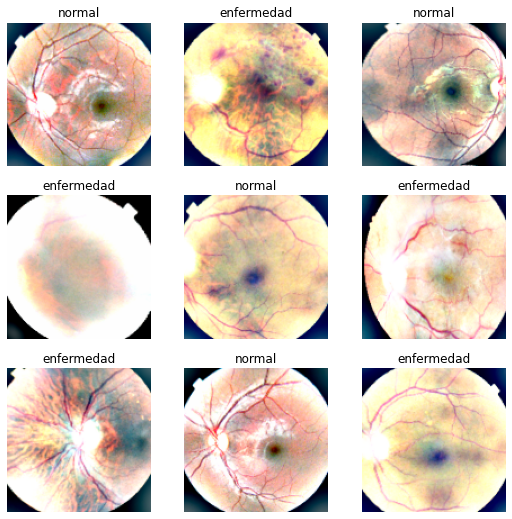

In [20]:
dls.show_batch()

In [21]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback(fname='modelResnet18')  
]

In [22]:
learn = cnn_learner(dls,resnet18,metrics=accuracy,cbs=callbacks).to_fp16()

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(minimum=0.010000000149011612, steep=0.009120108559727669, valley=0.0020892962347716093, slide=0.0063095735386013985)

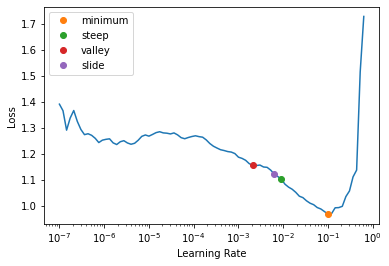

In [23]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,accuracy,time
0,1.074760,1.468499,0.492188,00:09


Better model found at epoch 0 with valid_loss value: 1.4684985876083374.


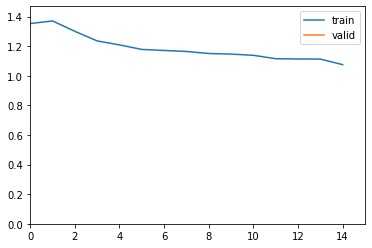

epoch,train_loss,valid_loss,accuracy,time
0,0.773493,0.789968,0.692187,00:09
1,0.743068,0.651308,0.764063,00:11
2,0.712070,0.545693,0.804688,00:08
3,0.671828,0.577777,0.812500,00:08
4,0.638053,0.584375,0.817187,00:08
5,0.595260,0.556998,0.834375,00:08
6,0.555323,0.553872,0.831250,00:08
7,0.519647,0.502918,0.850000,00:08
8,0.495260,0.510109,0.840625,00:08
9,0.459533,0.610703,0.839063,00:08


Better model found at epoch 0 with valid_loss value: 0.7899681925773621.


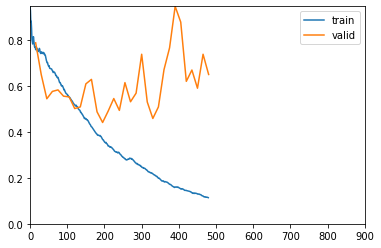

Better model found at epoch 1 with valid_loss value: 0.6513082981109619.
Better model found at epoch 2 with valid_loss value: 0.5456927418708801.
Better model found at epoch 7 with valid_loss value: 0.5029181241989136.
Better model found at epoch 11 with valid_loss value: 0.4887436032295227.
Better model found at epoch 12 with valid_loss value: 0.4421961307525635.
No improvement since epoch 12: early stopping


In [24]:
learn.fine_tune(60,base_lr=2e-3)

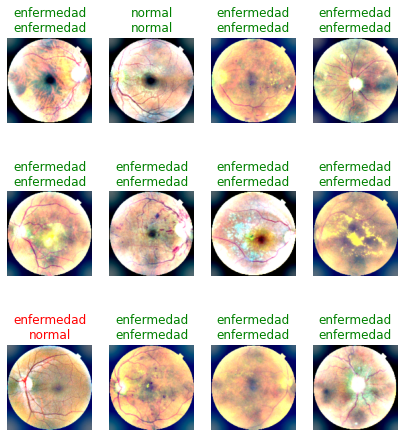

In [25]:
learn.show_results(max_n=12, figsize=(7,8))

Exportamos el modelo

In [26]:
learn.to_fp32()
learn.export('modeloBinario.pkl')

## Evaluando el modelo

In [27]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [28]:
learn.dls = dlsTest

El valor de la función de perdida es de 0.34 y su accuracy es del 80%.

In [29]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.8031250238418579.


(#2) [0.45532292127609253,0.8031250238418579]

## Interpretación del modelo

In [30]:
learn.dls=dls

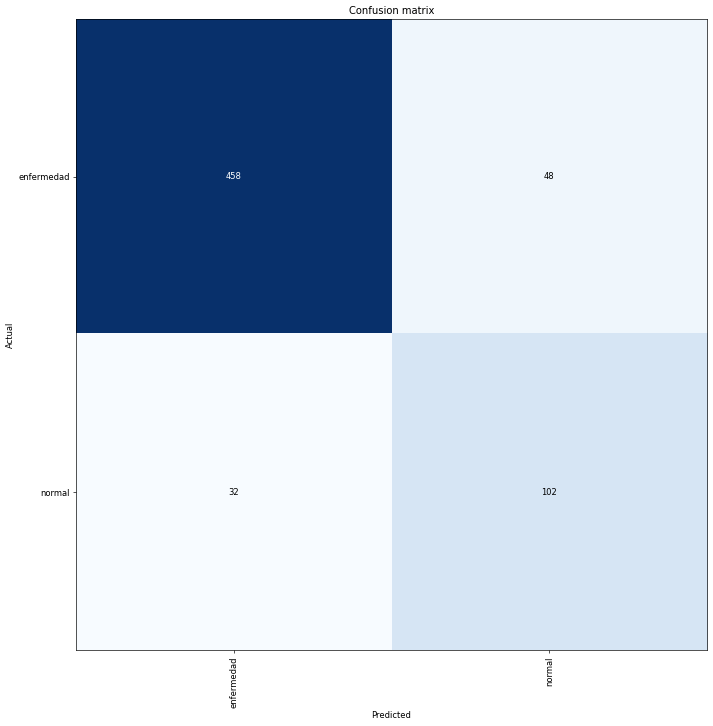

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)